In [17]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, RepeatVector
from tensorflow.keras.models import Model,load_model

In [18]:
# csv 파일의 데이터를 읽어서 원하는 값들만 추출 
def Read_Usedata(path):
    data = pd.read_csv(path)
    Usedata = pd.concat([data['pres_cm_in'],data['pres_mr'],data['temp_cm_oil'],data['curr_u'],data['valv_1'],data['pres_cm_in'],data['pres_mr']], axis=1)
    return Usedata

# sliding window
def sliding_window(data):
    X_train = []
    sequence_num = 100
    step = 10
    for i in range(0,len(data)-sequence_num,step):
        X_train.append(data[i:i+sequence_num])
    
    X_train = np.array(X_train)
    return X_train

# normalization
def normalization(data):
    pres_cm_in_max = 1000
    pres_cm_in_min = 0
    pres_mr_max = 900
    pres_mr_min = 600
    temp_cm_oil_max = 120
    temp_cm_oil_min = 20
    curr_u_max = 30
    curr_u_min = 0
    data.iloc[:,0]  = (data.iloc[:,0] -pres_cm_in_min)/(pres_cm_in_max-pres_cm_in_min)
    data.iloc[:,1]  = (data.iloc[:,1] -pres_mr_min)/(pres_mr_max-pres_mr_min)
    data.iloc[:,2]  = (data.iloc[:,2] -temp_cm_oil_min)/(temp_cm_oil_max-temp_cm_oil_min)
    data.iloc[:,3]  = (data.iloc[:,3] -curr_u_min)/(curr_u_max-curr_u_min)
    data.iloc[:,5]  = (data.iloc[:,5] -pres_cm_in_min)/(pres_cm_in_max-pres_cm_in_min)
    data.iloc[:,6]  = (data.iloc[:,6] -pres_mr_min)/(pres_mr_max-pres_mr_min)
    return data

# air compressor 가 동작할 때만 추출, 동작 2번하는 데이터는 제거
def extraction(data):
    data_1 = np.array(data['valv_1'])
    data_1 = list(data_1)
    a = []
    if data_1[0] == 0:
        mode = False
    else:
        mode = True

    for i in range(len(data_1)):    
        if mode == False:
            if data_1[i:i+50] == [1]*50:
                mode = not mode
                a.append(i)
        else:
            if data_1[i:i+50] == [0]*50:
                mode = not mode

    new_data = []
    for start_time in a:
        try:
            if data_1[start_time+500] == 1:
                continue
            new_data.append(data[start_time:start_time+500])
        except:
            pass

    return np.array(new_data)

# loss의 전체 평균을 구함
def loss_mae(X_test):
    X_pred = model.predict(X_test)
    
    loss_mae = []
    for i in range(len(list(X_pred))):
        loss = abs(X_test.reshape(X_test.shape[0],500,7)[i]-X_pred[i])
        loss_mae.append(loss.sum(axis=1).sum(axis=0)/1000)
    loss_mae = np.array(loss_mae)
    
    return loss_mae

In [19]:
# 학습 데이터 가져오기
train_datas = []
for i in range(30):
    train_datas.append(Read_Usedata('./data/205train/205train_cmsd_tc1_2020_12_%02d.csv' %(i+1)))

In [20]:
#normalization 및 작동 부위 추출
X_train = []
for train_data in train_datas:
    X_train_1 = normalization(train_data)
    X_train_2 = extraction(X_train_1)
    
    for data in X_train_2:
        X_train.append(data)
    
X_train = np.array(X_train)

#nan 값 제거
X_train_new = np.delete(X_train, list(np.where(np.isnan(X_train)==True)[0]),0)
X_train_new.shape

(4597, 500, 7)

In [22]:
# 모델 제작
def autoencoder_model(X):    
    x = tf.keras.layers.Input(shape=[500,7,1])
    
    H = tf.keras.layers.Conv2D(6, kernel_size = 4, activation = 'sigmoid')(x)
    H = tf.keras.layers.Conv2D(12, kernel_size = 4, activation = 'sigmoid')(H)
    
    H = tf.keras.layers.Flatten()(H)
    H = tf.keras.layers.Dense(512, activation = 'sigmoid')(H)
    H = tf.keras.layers.Dense(64, activation = 'sigmoid')(H)
    
    H = RepeatVector(X.shape[1])(H)
    H = LSTM(128,activation = 'sigmoid', return_sequences = True)(H)
    H = LSTM(64,activation = 'sigmoid', return_sequences = True)(H)
    H = LSTM(32,activation = 'sigmoid', return_sequences = True)(H)
    H = LSTM(20,activation = 'sigmoid', return_sequences = True)(H)
    Y = LSTM(7,activation = 'sigmoid', return_sequences = True)(H)
    
    model = Model(x, Y)
    
    return model

model = autoencoder_model(X_train_new)

adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam,loss='mae')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500, 7, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 497, 4, 6)         102       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 494, 1, 12)        1164      
_________________________________________________________________
flatten_1 (Flatten)          (None, 5928)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               3035648   
_________________________________________________________________
dense_3 (Dense)              (None, 64)                32832     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 500, 64)           0   

In [23]:
# 모델 훈련
model.fit(X_train_new.reshape(X_train_new.shape[0],500,7,1),X_train_new,epochs = 20, batch_size = 20, validation_split = 0.05)

Epoch 1/20
219/219 [==============================] - 124s 542ms/step - loss: 0.3128 - val_loss: 0.2756
Epoch 2/20
219/219 [==============================] - 122s 556ms/step - loss: 0.2628 - val_loss: 0.2703
Epoch 3/20
219/219 [==============================] - 119s 542ms/step - loss: 0.2447 - val_loss: 0.1814
Epoch 4/20
219/219 [==============================] - 118s 537ms/step - loss: 0.1712 - val_loss: 0.1648
Epoch 5/20
219/219 [==============================] - 118s 539ms/step - loss: 0.1544 - val_loss: 0.1446
Epoch 6/20
219/219 [==============================] - 121s 552ms/step - loss: 0.1483 - val_loss: 0.1808
Epoch 7/20
219/219 [==============================] - 118s 539ms/step - loss: 0.1465 - val_loss: 0.1583
Epoch 8/20
219/219 [==============================] - 129s 591ms/step - loss: 0.1485 - val_loss: 0.1447
Epoch 9/20
219/219 [==============================] - 127s 580ms/step - loss: 0.1438 - val_loss: 0.1806
Epoch 10/20
219/219 [==============================] - 127s 579m

In [31]:
model.save("CNN_AE_1.h5")

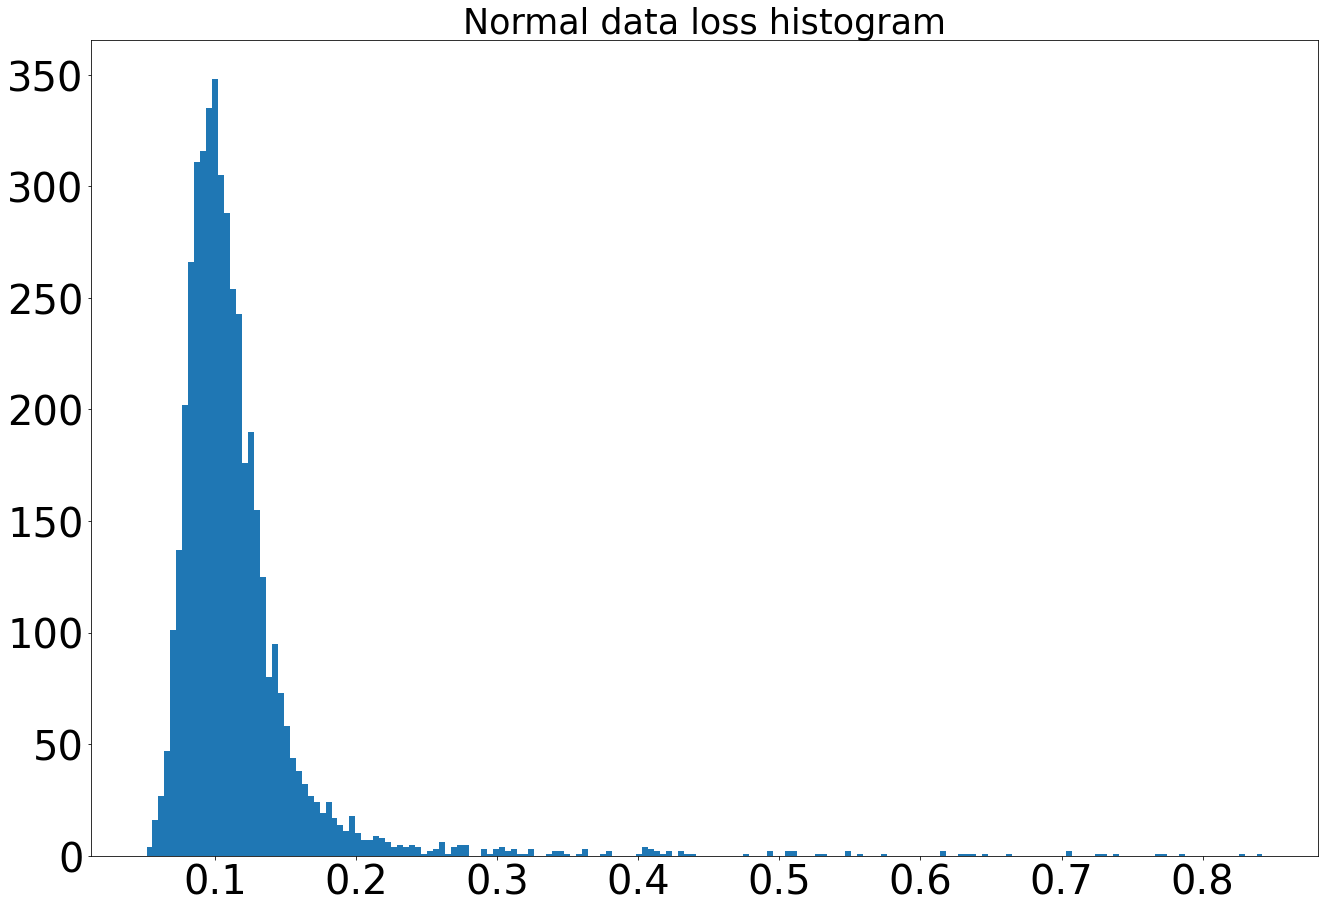

In [26]:
loss_mae_n = loss_mae(X_train_new)

plt.gcf().set_size_inches(22, 15)
plt.hist(loss_mae_n, bins='auto')  
plt.title("Normal data loss histogram")
plt.show()

In [27]:
# annomaly score 용 mean 값
X_pred = model.predict(X_train_new)
loss = X_pred-X_train_new.reshape(X_train_new.shape[0],500,7)
loss_mean = np.mean(loss,axis=1)
loss_mean = np.delete(loss_mean,np.array(np.where(loss_mae_n>0.4)),0)
loss_mean.shape
MEAN = np.mean(loss_mean,axis=0)
MEAN.shape

(7,)

In [28]:
# 공분산
VAR = np.cov(np.array(loss_mean-MEAN).T)
VAR.shape

(7, 7)

In [30]:
import pickle

with open('CNN_AE_1_MEAN.pickle', 'wb') as f:
    pickle.dump(MEAN, f, pickle.HIGHEST_PROTOCOL)
    
with open('CNN_AE_1_VAR.pickle', 'wb') as f:
    pickle.dump(VAR, f, pickle.HIGHEST_PROTOCOL)